In [1]:
import numpy as np
import pandas as pd
import s3fs
import fbprophet
import matplotlib.pyplot as plt
import seaborn as sns

from datetime import datetime

from htsprophet.hts import hts, orderHier, makeWeekly
from htsprophet.htsPlot import plotNode, plotChild, plotNodeComponents

from fbprophet import Prophet
from fbprophet.diagnostics import cross_validation, performance_metrics

In [2]:
data = pd.read_csv('s3://bsa-correlation-one/electronics_data.csv', dtype={'gtin':'str'})

In [3]:
df = data[['date', 'product_group','product_type', 'olist_price', 'orders']].copy()

In [4]:
df['olist_price'] = round(df.olist_price,2)

In [5]:
df = df.groupby(['date','product_group','product_type','olist_price']).sum().reset_index()

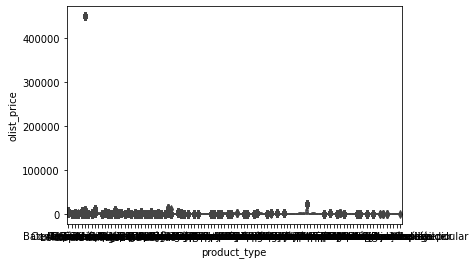

In [31]:
sns.boxplot(x='product_type', y='olist_price', data=df)

### Grouping products by type and price quantiles ranges

In [9]:
price_cat = {}
for prod_type in df.product_type.unique():
    temp = df[df.product_type == prod_type].copy()
    price_cat[prod_type] = np.quantile(temp.olist_price.values, np.arange(0.25,1,0.25))

In [19]:
def price_range(prod_category, price):
    prices = price_cat[prod_category]
    if price < prices[0]:
        return 'A'
    elif price < prices[1]:
        return 'B'
    elif price < prices[2]:
        return 'C'
    else:
        return 'D'

In [20]:
df['price_category'] = df.apply(lambda row: price_range(row['product_type'], row['olist_price']), axis=1)

In [21]:
df.head()

,date,product_group,product_type,olist_price,orders,price_category
0,2017-06-30,electronics,Celular,129.90,0.0,A
1,2017-06-30,electronics,Celular,169.90,0.0,A
2,2017-06-30,electronics,Celular,349.90,0.0,B
3,2017-06-30,electronics,Celular,813.63,0.0,C
4,2017-06-30,electronics,Controle remoto,42.50,0.0,D


### Group by price category and product_type:

In [24]:
df_gr = df.groupby(['date','product_group','product_type','price_category'])[['orders']].sum().reset_index()

In [25]:
df_gr.head()

,date,product_group,product_type,price_category,orders
0,2017-06-30,electronics,Celular,A,0.0
1,2017-06-30,electronics,Celular,B,0.0
2,2017-06-30,electronics,Celular,C,0.0
3,2017-06-30,electronics,Controle remoto,D,0.0
4,2017-06-30,electronics,Microfone,A,0.0


### holidays

In [26]:
def get_holidays():
    """
    Get Black Friday dates
    """
    black_friday = pd.DataFrame({
                  'holiday': 'black_friday',
                  'ds': pd.to_datetime(['2017-11-24', '2018-11-23', '2019-11-29',
                                        '2020-11-27', '2021-11-26', '2022-11-25',
                                        '2023-11-24', '2024-11-29', '2025-11-28']),
                  'lower_window': -1,
                  'upper_window': 3,
                })

    xmas = pd.DataFrame({
                  'holiday': 'christmas',
                  'ds': pd.to_datetime(['2017-12-25', '2018-12-25', '2019-12-25',
                                        '2020-12-25', '2021-12-25', '2022-12-25',
                                        '2023-12-25', '2024-12-25', '2025-12-25']),
                  'lower_window': -1,
                  'upper_window': 0,
                })

    new_year = pd.DataFrame({
                  'holiday': 'new_year',
                  'ds': pd.to_datetime(['2017-01-01', '2018-01-01', '2019-01-01',
                                        '2020-01-01', '2021-01-01', '2022-01-01',
                                        '2023-01-01', '2024-01-01', '2025-01-01']),
                  'lower_window': -1,
                  'upper_window': 0,
                })

    carnival = pd.DataFrame({
                  'holiday': 'carnival',
                  'ds': pd.to_datetime(['2017-02-28', '2018-02-13', '2019-03-05',
                                        '2020-02-25', '2021-02-16', '2022-03-01',
                                        '2023-02-21', '2024-02-13', '2025-03-04']),
                  'lower_window': -1,
                  'upper_window': 0,
                })

    good_friday = pd.DataFrame({
                  'holiday': 'good_friday',
                  'ds': pd.to_datetime(['2018-03-18','2019-04-19','2020-04-10',
                                        '2021-04-02','2022-04-15','2023-04-07',
                                        '2024-03-29']),
                  'lower_window': 0,
                  'upper_window': 2,
                })

    # long holidays

    monday = pd.DataFrame({
                  'holiday': 'monday',
                  'ds': pd.to_datetime(['2020-09-07','2020-10-12','2020-11-02',
                                        '2021-11-15']),
                  'lower_window': -2,
                  'upper_window': 0,
                })

    friday = pd.DataFrame({
                  'holiday': 'friday',
                  'ds': pd.to_datetime(['2018-09-07','2018-10-12','2018-11-02',
                                        '2019-11-15','2020-05-01']),
                  'lower_window': 0,
                  'upper_window': 2,
                })

    # Different cases
    # 2019-12-30 (christmas and New year's eve from tuesday to wednesday. Monday was also affected)
    others = pd.DataFrame({
                  'holiday': 'others',
                  'ds': pd.to_datetime(['2019-12-23','2019-12-30']),
                  'lower_window': 0,
                  'upper_window': 0,
                })

    holidays = pd.concat((black_friday, xmas, new_year, carnival,
                         monday, friday, others))

    return holidays

In [27]:
holidays = get_holidays()

### htsprophet

In [28]:
df_gr.head()

,date,product_group,product_type,price_category,orders
0,2017-06-30,electronics,Celular,A,0.0
1,2017-06-30,electronics,Celular,B,0.0
2,2017-06-30,electronics,Celular,C,0.0
3,2017-06-30,electronics,Controle remoto,D,0.0
4,2017-06-30,electronics,Microfone,A,0.0


In [58]:
start = datetime.now()
data_hts, nodes = orderHier(df_gr, 1, 2, 3)
end = datetime.now()
print('Executed in: {}'.format(end-start))

Executed in: 0:00:19.432320


In [59]:
data_hts.head()

,time,Total,electronics,electronics_Celular,electronics_Controle remoto,electronics_Microfone,electronics_Bateria para notebook,electronics_Caixa de som,electronics_Fone de ouvido,electronics_Potenciômetro,...,electronics_Tecla botão home para celular_C,electronics_Tecla botão home para celular_D,electronics_Processador de áudio_A,electronics_Processador de áudio_B,electronics_Processador de áudio_C,electronics_Processador de áudio_D,electronics_Botoeira de sobrepor_A,electronics_Botoeira de sobrepor_B,electronics_Botoeira de sobrepor_C,electronics_Botoeira de sobrepor_D
0,2017-06-30,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
1,2017-07-01,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
2,2017-07-02,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
3,2017-07-03,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
4,2017-07-04,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


In [60]:
data_hts['time'] = pd.to_datetime(data_hts['time'])

In [61]:
data_hts.shape

(974, 508)

In [62]:
start = datetime.now()
myDict = hts(data_hts, 7, nodes, holidays = holidays, method = "FP")
end = datetime.now()
print('Executed in: {}'.format(end-start))

SystemExit: The sum of the nodes list does not equal the number of columns - 2, dataframe should contain a time column in the 0th pos. Double check node input

/home/ubuntu/.local/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3339: UserWarning:

To exit: use 'exit', 'quit', or Ctrl-D.



### fbprophet bottom-up approach

In [67]:
cols = [each for each in data_hts.columns if len(each.split('_')) == 3]

In [75]:
cols[0]

'electronics_Celular_A'

In [83]:
for each in ['electronics_Celular_A']:
    temp = data_hts[['time', each]]
    temp.rename(columns={'time':'ds', each:'y'}, inplace=True)
    model = Prophet(holidays=holidays)
    model.fit(temp)
    future = model.make_future_dataframe(periods=7, freq='D', include_history=True)
    fcst = model.predict(future)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


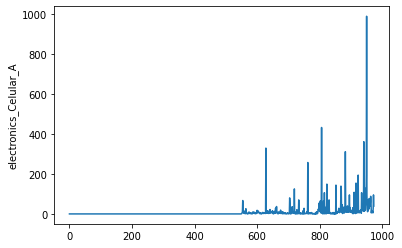

In [79]:
model.p